In [1]:
import os
from pathlib import Path
current_directory = Path().resolve()
os.chdir(Path(current_directory).resolve().parent.parent)

import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import chardet

plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = False

file_path = current_directory / "conversion_df.csv"

if not file_path.exists():
    raise Exception(f"File {file_path} does not exist.")

with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

df = pd.read_csv(file_path, encoding=file_encoding, sep=',')

df.head()

temperature  rate_3_diff_reaction_0_conversion  \
0     30.27800                       9.827818e-08   
1     31.23291                       2.018687e-07   
2     32.18783                       3.111036e-07   
3     33.14274                       4.263148e-07   
4     34.09766                       5.478344e-07   

   rate_3_diff_reaction_1_conversion  rate_3_diff_reaction_2_conversion  \
0                       9.972903e-14                       1.085497e-95   
1                       2.095083e-13                       3.233271e-95   
2                       3.302654e-13                       7.470771e-95   
3                       4.630829e-13                       1.585870e-94   
4                       6.091975e-13                       3.248944e-94   

   rate_3_diff_reaction_3_conversion  rate_5_diff_reaction_0_conversion  \
0                       4.368624e-31                       1.631908e-08   
1                       9.677860e-31                       3.357247e-08   
2                       1.613673e-30                       5.182243e-08   
3                       2.399608e-30                       7.113127e-08   
4                       3.352762e-30                       9.156127e-08   

   rate_5_diff_reaction_1_conversion  rate_5_diff_reaction_2_conversion  \
0                       1.548049e-12                      9.211130e-119   
1                       3.220325e-12                      2.961691e-118   
2                       5.035938e-12                      7.472155e-118   
3                       6.994890e-12                      1.749843e-117   
4                       9.129032e-12                      3.969752e-117   

   rate_5_diff_reaction_3_conversion  rate_10_diff_reaction_0_conversion  \
0                       4.843107e-36                        2.327450e-08   
1                       1.081627e-35                        4.776307e-08   
2                       1.820201e-35                        7.349531e-08   
3                       2.734337e-35                        1.005601e-07   
4                       3.864396e-35                        1.290165e-07   

   rate_10_diff_reaction_1_conversion  rate_10_diff_reaction_2_conversion  \
0                        7.123818e-12                       6.808762e-155   
1                        1.474954e-11                       2.450654e-154   
2                        2.290955e-11                       7.056580e-154   
3                        3.165242e-11                       1.899695e-153   
4                        4.101052e-11                       5.003689e-153   

   rate_10_diff_reaction_3_conversion  
0                        2.411354e-26  
1                        5.173075e-26  
2                        8.346994e-26  
3                        1.199494e-25  
4                        1.615813e-25

$$ Безмодельные~методы $$
Как говорилось выше, уравнение 15 не имеет аналитического решения. По этой причине существует ряд интегральных изоконверсионных методов, которые отличаются аппроксимациями температурного интеграла $p(x)$. Многие из этих аппроксимаций приводят к линейным уравнениям общего вида:

$$\ln\left(\frac{{\alpha}_i}{T^B_i}\right) = \text{Const} - \frac{CE_a}{RT_a} \tag{21}$$

где B и C - параметры, определяемые типом аппроксимации температурного интеграла. Например, очень грубая аппроксимация Дойля, которая была выполнена для $x = 28–50$, где $x = \frac{Ea}{RT}$, дает B = 0 и C = 1.052, так что уравнение (21) принимает форму, также известную как уравнение Озавы, и/или Флинна и Уолла:

$$\ln({\alpha}_i) = \text{Const} - \frac{1.052E_a}{RT_a} \tag{22}$$

Грубая аппроксимация температурного интеграла приводит к неточным значениям $E_a$. Более точную аппроксимацию дают Мюррей и Уайт, они получают B = 2 и C = 1 и приводят к другому популярному уравнению, которое часто называют уравнением Киссинджера-Акахира-Суносе:

$$\ln\left(\frac{{\alpha}_i}{T^2_i}\right) = \text{Const} - \frac{E_a}{RT_a} \tag{23}$$

По сравнению с методом Озавы-Флинна-Уолла, метод Киссинджера-Акахира-Суносе предлагает значительное улучшение точности значений $E_a$. Как показал Старинк, несколько более точные оценки $E_a$ достигаются при установке B = 1.92 и C = 1.0008, так что уравнение (21) преобразуется в:

$$\ln\left(\frac{{\alpha}_i}{T^{1.92}_i}\right) = \text{Const} - \frac{1.0008E_a}{RT_a} \tag{24}$$

Поскольку вышеупомянутые уравнения (21) - (24) одинаково легко решить, применяя анализ линейной регрессии, рекомендуется использовать более точные уравнения, такие как (23) и (24).  Здесь следует настоятельно рекомендовать против часто встречающейся практики выполнения и отчетности по кинетическому анализу на основе одновременного использования более чем одной формы уравнения (21). Одновременное использование двух или более таких уравнений только раскрывает тривиальное различие в значениях $E_a$, вычисленных методами разной точности. Поскольку из такого сравнения не получается кинетическая информация, практику одновременного использования уравнений (21) - (24) следует исключить в пользу использования только одного более точного уравнения.


<Axes: xlabel='conversion'>

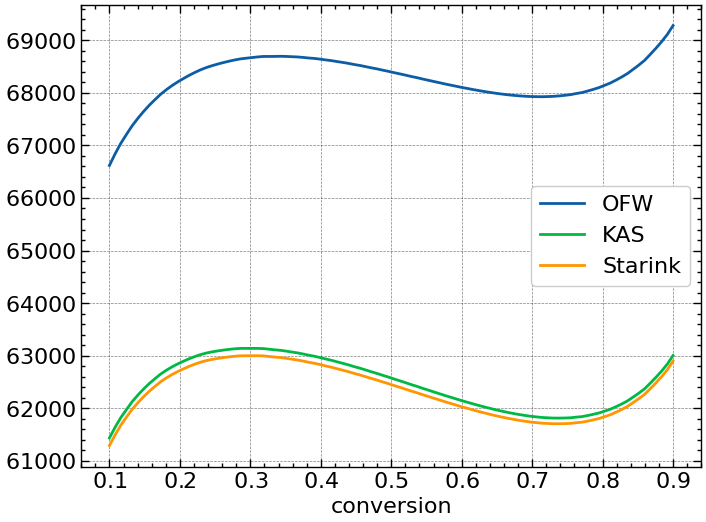

In [2]:
import numpy as np
import scipy.stats as stats
from scipy.constants import R
from scipy.interpolate import interp1d

ALPHA_MIN = 0.1 # Минимальная конверсия
ALPHA_MAX = 0.9 # Максимальная конверсия
reaction_n = "reaction_0"
reaction_cols = [
    f"rate_3_diff_{reaction_n}_conversion",
    f"rate_5_diff_{reaction_n}_conversion",
    f"rate_10_diff_{reaction_n}_conversion",
]
_df = df[[*reaction_cols]].copy()
dadt_data = [_df[col].diff() for col in _df]
reaction_df = pd.DataFrame(dadt_data).T
reaction_df["temperature"] = df["temperature"] + 273.15
reaction_df.columns = ["3", "5", "10", "temperature"]

def fetch_linear_approx_Ea(reaction_df: pd.DataFrame) -> pd.DataFrame:
    rate_cols = [col for col in reaction_df.columns if col != "temperature"]

    conv = reaction_df[rate_cols].cumsum() / reaction_df[rate_cols].cumsum().max()
    temperature = reaction_df["temperature"]

    valid = temperature.notna() & conv.notna().all(axis=1)
    conv, temperature = conv[valid], temperature[valid]

    f = {rate: interp1d(conv[rate], temperature, bounds_error=False, fill_value="extrapolate")
         for rate in rate_cols}

    lower_bound = max(conv.min().min(), ALPHA_MIN)
    upper_bound = min(conv.max().max(), ALPHA_MAX)

    conv_grid = np.linspace(lower_bound, upper_bound, 100)

    T = np.column_stack([f[rate](conv_grid) for rate in rate_cols])
    X = 1.0 / T
    x_mean = X.mean(axis=1, keepdims=True)
    denom = ((X - x_mean) ** 2).sum(axis=1)

    rates = np.array([float(rate) for rate in rate_cols])
    log_rates = np.log(rates)

    # OFW: y = ln(β)
    Y_OFW = np.tile(log_rates, (100, 1))
    slope_OFW = ((X - x_mean) * (Y_OFW - Y_OFW.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    # KAS: y = ln(β) - 2·ln(T)
    Y_KAS = log_rates - 2 * np.log(T)
    slope_KAS = ((X - x_mean) * (Y_KAS - Y_KAS.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    # Starink: y = ln(β) - 1.92·ln(T)
    Y_Starink = log_rates - 1.92 * np.log(T)
    slope_Starink = ((X - x_mean) * (Y_Starink - Y_Starink.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    Ea_OFW = slope_OFW * R / -1.052
    Ea_KAS = slope_KAS * R / -1.0
    Ea_Starink = slope_Starink * R / -1.008

    return pd.DataFrame({
        "conversion": conv_grid,
        "OFW": Ea_OFW,
        "KAS": Ea_KAS,
        "Starink": Ea_Starink
    })

result_df = fetch_linear_approx_Ea(reaction_df)

result_df.plot(x="conversion")


$$ Метод~Фридмана $$

Этот метод является дифференциальным и был одним из первых методов изоконверсии. Логарифм изотермического закона скорости (Ур. 9) дает:

$$ \ln \left( \frac{d\alpha}{dT} \right) = \ln \left(\frac{A}{\beta}f(\alpha) \right) - \frac{E_\alpha}{RT} \quad \tag{25}$$

Построение графика $\ln \left( \frac{d\alpha}{dt} \right)$ против $\frac{1}{T}$ на каждом $\alpha$ дает $E_\alpha$ из наклона для этого $\alpha$ независимо от модели.


<Axes: xlabel='conversion'>

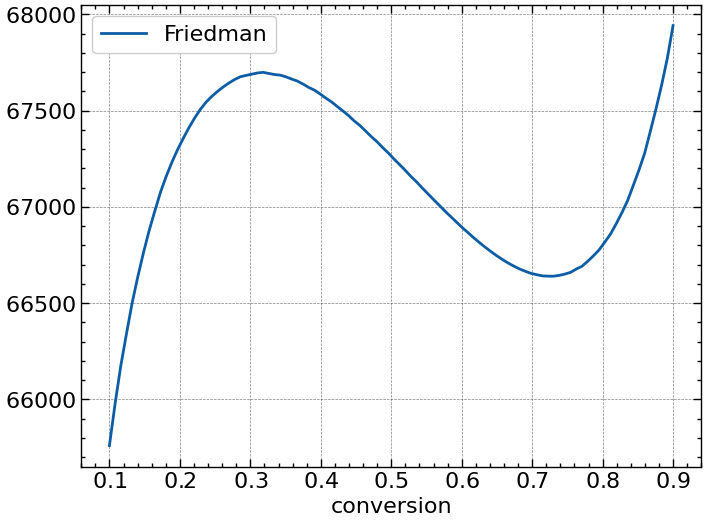

In [3]:
def fetch_friedman_Ea(reaction_df: pd.DataFrame) -> pd.DataFrame:
    rate_cols = [col for col in reaction_df.columns if col != "temperature"]

    conv = reaction_df[rate_cols].cumsum() / reaction_df[rate_cols].cumsum().max()
    temperature = reaction_df["temperature"]

    valid = temperature.notna() & conv.notna().all(axis=1)
    conv, temperature = conv[valid], temperature[valid]

    f = {
        rate: interp1d(conv[rate], temperature, bounds_error=False, fill_value="extrapolate")
        for rate in rate_cols
    }

    lower_bound = max(conv.min().min(), ALPHA_MIN)
    upper_bound = min(conv.max().max(), ALPHA_MAX)
    conv_grid = np.linspace(lower_bound, upper_bound, 100)

    T = np.column_stack([f[rate](conv_grid) for rate in rate_cols])
    X = 1.0 / T

    x_mean = X.mean(axis=1, keepdims=True)
    denom = ((X - x_mean) ** 2).sum(axis=1)

    rates = np.array([float(rate) for rate in rate_cols])
    log_rates = np.log(rates)  # ln(β)

    # ln(dα/dT) = ln(β) - ln(T)
    Y_Friedman = np.tile(log_rates, (len(conv_grid), 1)) - np.log(T)
    slope_Friedman = ((X - x_mean) * (Y_Friedman - Y_Friedman.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    Ea_Friedman = -slope_Friedman * R

    return pd.DataFrame({
        "conversion": conv_grid,
        "Friedman": Ea_Friedman
    })

result_df = fetch_friedman_Ea(reaction_df)

result_df.plot(x="conversion")

In [4]:
def fetch_kissinger_Ea(reaction_df: pd.DataFrame) -> pd.DataFrame:
    rate_cols = [col for col in reaction_df.columns if col != "temperature"]

    temperature_K = reaction_df["temperature"]

    peak_points = []
    for col in rate_cols:
        series = reaction_df[col]

        valid = series.notna() & temperature_K.notna()
        if valid.sum() == 0:
            continue

        cum = series[valid].cumsum()
        conv = cum / cum.iloc[-1]

        idx_peak = series.idxmax()
        T_peak = temperature_K.loc[idx_peak]
        alpha_peak = conv.loc[idx_peak]
        beta_val = float(col)
        peak_points.append((beta_val, T_peak, alpha_peak))

    peak_points.sort(key=lambda x: x[2])

    beta_vals = np.array([pt[0] for pt in peak_points], dtype=float)
    T_peaks = np.array([pt[1] for pt in peak_points], dtype=float)
    alphas = np.array([pt[2] for pt in peak_points], dtype=float)
    
    # X = 1/Tₚ, Y = ln(β / Tₚ²)
    X = 1.0 / T_peaks
    Y = np.log(beta_vals / (T_peaks ** 2))
    slope, intercept = np.polyfit(X, Y, 1)
    E_a = -slope * R

    result_df = pd.DataFrame({
        "conversion": alphas,
        "Kissinger_Ea": [E_a] * len(alphas)
    })
    return result_df

result_df = fetch_kissinger_Ea(reaction_df)

result_df

conversion  Kissinger_Ea
0    0.654178   57500.04117
1    0.657866   57500.04117
2    0.700434   57500.04117

$$ Метод~Вязовкина $$ 
Интеграл по температуре $p(x)$ в неизотермическом законе скорости (уравнение 17) является функцией Ea и температуры. Поэтому уравнение 17 можно записать следующим образом:

$$g({\alpha}) = \frac{AEa}{\beta R} I(Ea,T) \tag{26}$$

где $I(Ea, T) = p(x)$. Общее предположение, используемое в методе Вязовкина (или любом другом изоконверсионном методе), состоит в том, что модель реакции не зависит от скорости нагрева (т. е. $g_{\alpha}$ будет одинаковой при любой скорости нагрева). Поэтому для значения превращения $(\alpha)$ можно определить следующее отношение, если применяются две скорости нагрева:

$$ g({\alpha}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_1R} I(E_{a\alpha},T_{\alpha 1}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_2 R} I(E_{a\alpha},T_{\alpha 2}) \tag{27} $$

где $\beta_1$ - первая скорость нагрева, $\beta_2$ - вторая скорость нагрева, $T_{\alpha 1}$ - температура для определенного значения $\alpha$ при использовании первой скорости нагрева, $T_{\alpha 2}$ - температура при том же значении $\alpha$ при использовании второй скорости нагрева, $E_{a\alpha}$ - энергия активации при этом значении $\alpha$ и $A_{\alpha}$ - частотный фактор при этом значении $\alpha$. Для эксперимента с "n" скоростями нагрева отношение будет следующим:

$$ g({\alpha}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_1 R} I(E_{a\alpha},T_{\alpha 1}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_2 R} I(E_{a\alpha},T_{\alpha 2}) = ... = \frac{A_{\alpha} E_{a\alpha}}{\beta_n R} I(E_{a\alpha},T_{\alpha n}) \tag{28}$$ 

что сводится к:

$$ \frac{I(E_{a\alpha}, T_{\alpha 1})}{\beta_1} = \frac{I(E_{a\alpha}, T_{\alpha 2})}{\beta_2} = ... = \frac{I(E_{a\alpha}, T_{\alpha n})}{\beta_n} = \sigma \tag{29} $$

где $\sigma$ - константа.

Для двух скоростей нагрева, используя два члена в уравнении 29, мы получаем:

$$ \frac{I(E_{a\alpha},T_{\alpha 1})}{\beta_1} = \frac{I(E_{a\alpha},T_{\alpha 2})}{\beta_2} = \sigma \tag{30} $$

Если обе стороны разделить на правый или левый член, мы получаем либо:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} = 1 \tag{31} $$ 

или

$$ \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} = 1 \tag{32} $$

Объединение уравнения 31 и уравнения 32 дает:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} + \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} = 2 \tag{33} $$

Для трех скоростей нагрева можно получить аналогичное уравнение, как показано ниже:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} + \frac{\beta_3}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 3})} + \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} + \frac{\beta_3}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 3})} + \frac{\beta_1}{\beta_3}\frac{I(E_{a\alpha},T_{\alpha 3})}{I(E_{a\alpha},T_{\alpha 1})} + \frac{\beta_2}{\beta_3}\frac{I(E_{a\alpha},T_{\alpha 3})}{I(E_{a\alpha},T_{\alpha 2})} = 6 \tag{34} $$

Для "n" скоростей нагрева уравнения 33 и 34 можно обобщить как:

$$ \sum_{i=1}^{n} \sum_{j \neq i} \frac{\beta_jI(E_{a\alpha},T_{\alpha i})}{\beta_iI(E_{a\alpha},T_{\alpha j})} = n(n-1) \tag{35} $$

или

$$ n(n-1) \sum_{i=1}^{n} \sum_{j \neq i} \frac{\beta_jI(E_{a\alpha},T_{\alpha i})}{\beta_iI(E_{a\alpha},T_{\alpha j})} = 0 \tag{36} $$

где температурный интеграл:

$$
I(E_\alpha, T_\alpha) = \int_0^{T_a} \exp \left(-\frac{E_\alpha}{RT}\right) dT \tag{37}
$$

Этот интеграл решается численно. Минимизация повторяется для каждого значения $\alpha$, чтобы получить зависимость $Ea$ от $\alpha$. 

Все рассмотренные до сих пор интегральные изоконверсионные уравнения (21–24, 36) основаны на решении температурного интеграла при предположении, что значение $Ea$  остается постоянным на всем интервале интеграции, то есть $Ea$  не зависит от $\alpha$. На практике $Ea$  часто изменяется с $\alpha$. Нарушение предположения о постоянстве $Ea$  вносит систематическую ошибку в значение $Ea$. Ошибка может быть значительной, до 20–30% в случае сильных изменений $Ea$  с $\alpha$. Эта ошибка не возникает в дифференциальном методе и может быть устранена в интегральных методах путем интегрирования по малым сегментам температуры или времени. Такой тип интеграции легко вводится в уравнение (36) путем вычисления температурного интеграла как:

$$
I(E_\alpha, T_\alpha) = \int_{T_a - d\alpha}^{T_a} \exp \left(-\frac{E_\alpha}{RT}\right) dT \tag{38}
$$


In [5]:
from scipy.integrate import quad

def calculate(reaction_df: pd.DataFrame) -> pd.DataFrame:
        beta_cols = [col for col in reaction_df.columns if col != "temperature"]

        conv_df = pd.DataFrame()
        for col in beta_cols:
            cum = reaction_df[col].cumsum()
            conv_df[col] = cum / cum.iloc[-1]
        temperature = reaction_df["temperature"]

        f_funcs = {
            col: interp1d(conv_df[col], temperature, bounds_error=False, fill_value="extrapolate")
            for col in beta_cols
        }


        conv_grid = np.linspace(ALPHA_MIN, ALPHA_MAX, 100)

        T_matrix = {}
        for col in beta_cols:
            T_matrix[col] = f_funcs[col](conv_grid)

        beta_vals = {col: float(col) for col in beta_cols}

        dT = reaction_df["temperature"].diff().mean()

        def integrand(T, Ea):
            return np.exp(-Ea / (R * T))

        def I_func(Ea, T, dT):
            integral, _ = quad(integrand, T - dT, T, args=(Ea,))
            return integral

        def vyazovkin_lhs(Ea, dT, pairs):
            n = len(pairs)
            sum_ratio = 0.0
            for i in range(n):
                T_i, beta_i = pairs[i]
                for j in range(n):
                    if i != j:
                        T_j, beta_j = pairs[j]
                        I_i = I_func(Ea, T_i, dT)
                        I_j = I_func(Ea, T_j, dT)
                        sum_ratio += (beta_j / beta_i) * (I_i / I_j)

            result = (n * (n - 1) - sum_ratio) * -1
            return result

        candidate_Ea = np.arange(10000, 300001, 1000)
        estimated_Ea = []

        for idx, alpha in enumerate(conv_grid):
            pairs = []
            for col in beta_cols:
                pairs.append((T_matrix[col][idx], beta_vals[col]))

            f_vals = [abs(vyazovkin_lhs(Ea, dT, pairs)) for Ea in candidate_Ea]
            best_index = np.argmin(f_vals)
            best_Ea = candidate_Ea[best_index]
            estimated_Ea.append(best_Ea)

        result_df = pd.DataFrame({"conversion": conv_grid, "Vyazovkin": estimated_Ea})
        return result_df

# result_df = calculate(reaction_df)

# result_df.plot(x="conversion")

$$ y(\alpha)~и~z(\alpha)~мастер~графики $$
После нахождения $Ea$ безмодельным методом, необходимо убедиться, что она не меняется значительно в зависимости от $\alpha$. Затем приближенно постоянное значение $Ea$ можно заменить средним значением $E_0$, которое подставляется в уравнения (40) или (39). Функция $y(\alpha)$ имеет следующую форму:

$$ y(\alpha) = \frac{d\alpha}{dt}_a \exp\left(\frac{E_0}{RT_\alpha}\right) = Af(\alpha) \tag{40} $$

Уравнение (40) легко получается путем перестановки уравнения дифференциальной формы неизотермического закона скорости реакции (9). Значения $y(\alpha)$ определяются непосредственно из экспериментальных данных путем подстановки $E_0$ в уравнение (40). Затем для каждого значения $\alpha$ необходимо определить экспериментальные значения $(d\alpha/dt)_a$ и $T_\alpha$, связанные с этим $\alpha$, и вставить их в уравнение (40). Полученные в результате экспериментальные значения $y(\alpha)$ строятся в виде функции от $\alpha$ и сравниваются с теоретическими мастер графиками $y(\alpha)$. Подходящая модель определяется как наилучшее соответствие между экспериментальными и теоретическими главными графиками $y(\alpha)$.

Как видно из уравнения (40), форма теоретических мастер графиков $y(\alpha)$ полностью определяется формой функций $f(\alpha)$, поскольку $A$ является постоянной. Однако, поскольку предэкспоненциальный фактор еще не известен, экспериментальные и теоретические графики $y(\alpha)$ должны быть нормализованы. По практическим причинам графики $y(\alpha)$ нормализуются так, чтобы они варьировались от 0 до 1. Тип модели реакции можно распознать по форме экспериментального графика $y(\alpha)$.

Мастер график $z(\alpha)$ получаются путем объединения дифференциальной и интегральной форм моделей реакции. Интеграл температуры в уравнении (15) может быть заменен на различные приближения, $\pi(x)$ следующим образом:

$$g(a) = \frac{AE}{\beta R}\exp(-x)\pi(x)/x \tag{41}$$

где $x = E/RT$. Комбинирование уравнений (9) и (41), за которым следует некоторая перестановка, позволяет ввести функцию $z(\alpha)$ в виде:

$$z(\alpha) = f(\alpha)g(\alpha) = \frac{da}{dt}_a T^2_\alpha \frac{\pi(x)}{\beta T_\alpha} \tag{42}$$

Установлено, что член дроби уравнения (42) оказывает пренебрежимое влияние на форму функции $z(\alpha)$. Таким образом, значения $z(\alpha)$ можно определить для каждого значения $\alpha$, умножив экспериментальные значения $da/dt_a$ и $T^2_a$. Полученные в результате экспериментальные значения $z(\alpha)$ строятся в виде функции от $\alpha$ и сравниваются с теоретическими мастер графиками $z(\alpha)$. Подходящая модель определяется как наилучшее соответствие между экспериментальными и теоретическими мастер графиками $z(\alpha)$. Из серии экспериментальных кинетических кривых, измеренных при различных $\beta$, можно получить серию экспериментальных графиков $z(\alpha)$, которые, однако, должны давать единственную зависимость $z(\alpha)$ от $\alpha$, практически независимую от $\beta$. Теоретические графики $z(\alpha)$ получаются путем построения произведения $f(\alpha)g(\alpha)$ против $\alpha$ для различных моделей реакции.

Следует отметить, что графики $z(\alpha)$ демонстрируют максимум при определенном значении конверсии, $a_p$, который может быть найден из условия:

$$g(\alpha)f'(\alpha) = -1 \tag{43}$$

Значения $a_p$ были рассчитаны для ряда моделей реакции. Значения могут оказать некоторую дополнительную помощь при определении подходящих моделей реакции для экспериментальных данных. Как только модель реакции была идентифицирована, предэкспоненциальный фактор определяется из следующего уравнения:

$$ A =  \frac{-\beta E_0}{R T^2_{max} f'(a_{max})}\exp\left(\frac{E_0}{RT_{max}}\right) \tag{44} $$

В уравнении (44) индекс $max$ обозначает значения, связанные с максимумом дифференциальной кинетической кривой, полученной при данной скорости нагрева.

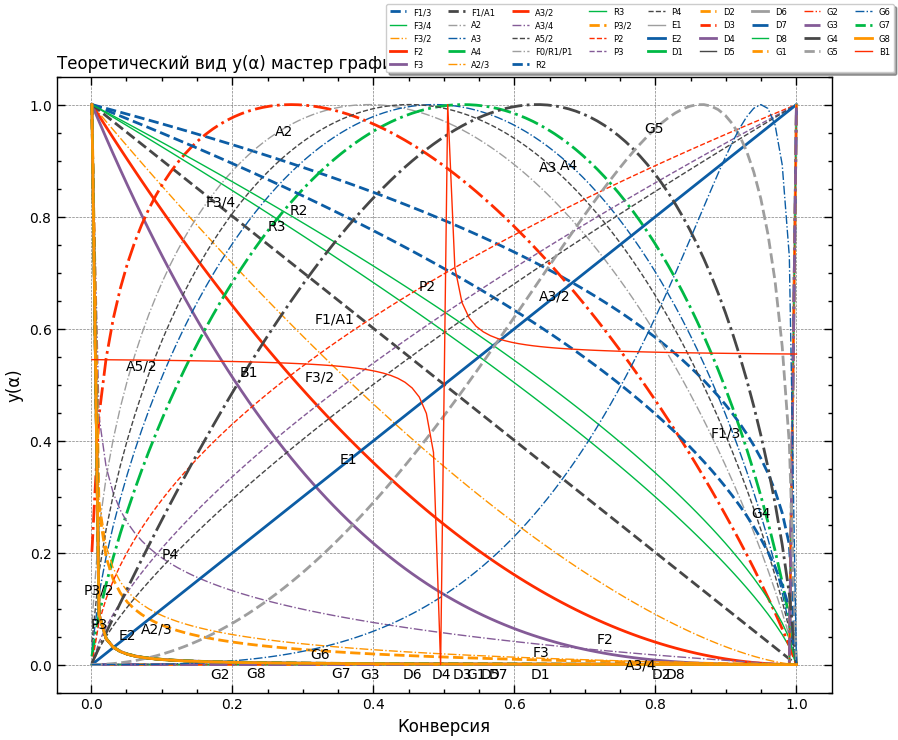

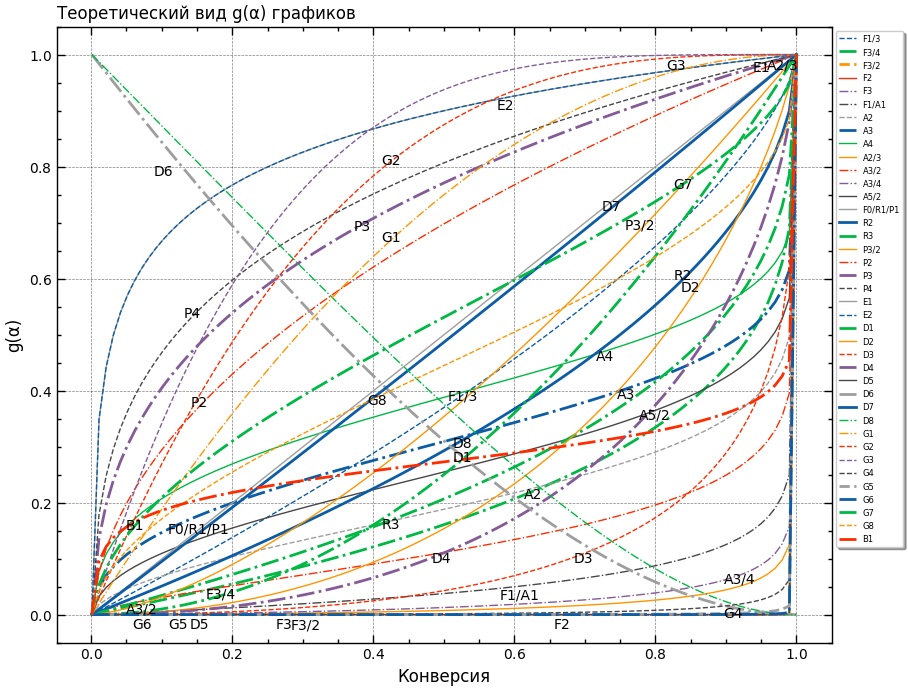

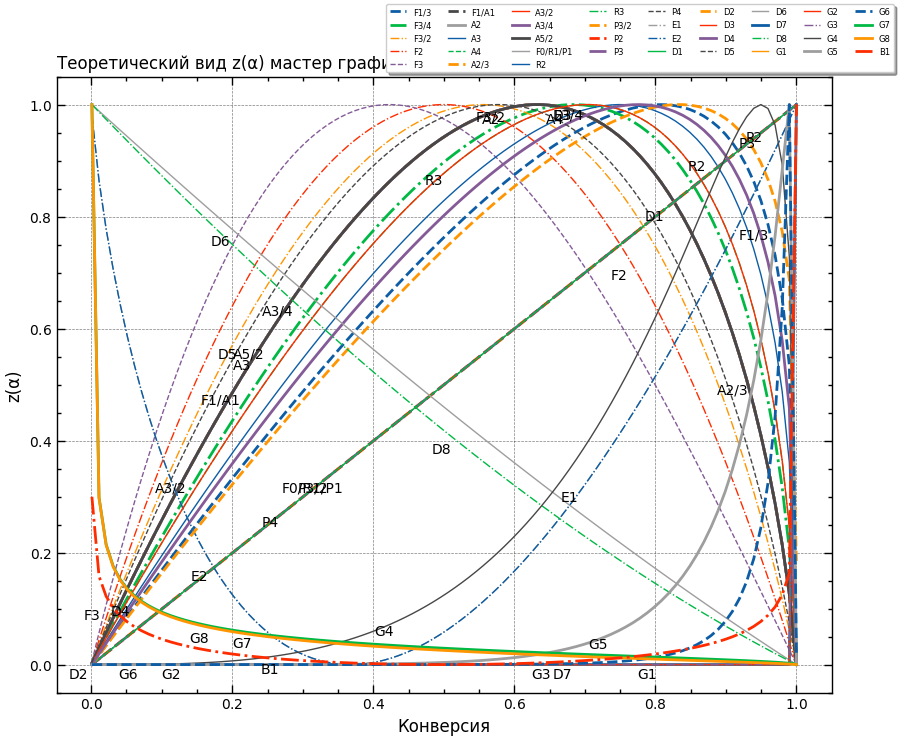

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Для генерации случайных стилей линий
def get_random_line_style_and_width():
    line_styles = ['-', '--', '-.']
    line_widths = [1, 2]
    return np.random.choice(line_styles), np.random.choice(line_widths)

def normalize_data(data):
    if np.isinf(np.max(data)) or np.isnan(np.max(data)):
        data_max = np.nanmax(data[~np.isinf(data) & ~np.isnan(data)])
    else:
        data_max = np.max(data)
                
    if np.isinf(np.min(data)) or np.isnan(np.min(data)):
        data_min = np.nanmin(data[~np.isinf(data) & ~np.isnan(data)])
    else:
        data_min = np.min(data) 
    return (data - data_min) / (data_max - data_min)

MEDIUM_SIZE = 12
SMALL_SIZE = 10

# Импортируем словарь с моделями
from src.core.app_settings import NUC_MODELS_TABLE

def plot_y(a, models_table):
    fig, ax = plt.subplots(figsize=(10, 8))
    e = 1 - a
    
    for model, funcs in models_table.items():
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                y = funcs['differential_form'](e)
                y_norm = normalize_data(y)
                
                line_style, line_width = get_random_line_style_and_width()
                ax.plot(a, y_norm, label=model, linestyle=line_style, linewidth=line_width)
                                
                # Добавляем метку модели в случайной точке графика
                rand_index = np.random.choice(range(len(a)))
                ax.annotate(model, (a[rand_index], y_norm[rand_index]),
                            textcoords="offset points", xytext=(-10, -10), ha='center')
        except Exception as exc:
            print(f"Проблема с моделью {model}: {str(exc)}")
    
    ax.legend(loc='best', bbox_to_anchor=(0.42, 1.00), ncol=9, fancybox=True, shadow=True, prop={'size': 6})
    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
    ax.set_title('Теоретический вид y(α) мастер графиков', fontsize=MEDIUM_SIZE, loc='left')
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    plt.show()

def plot_g(a, models_table):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    e = 1 - a
    for model, funcs in models_table.items():
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                g = funcs['integral_form'](e)
                g_norm = normalize_data(g)
                
                line_style, line_width = get_random_line_style_and_width()
                ax.plot(a, g_norm, label=model, linestyle=line_style, linewidth=line_width)
                
                rand_index = np.random.choice(range(len(a)))
                ax.annotate(model, (a[rand_index], g_norm[rand_index]),
                            textcoords="offset points", xytext=(-10, -10), ha='center')
        except Exception as exc:
            print(f"Проблема с моделью {model}: {str(exc)}")
            
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, prop={'size': 6})
    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('g(α)', fontsize=MEDIUM_SIZE)
    ax.set_title('Теоретический вид g(α) графиков', fontsize=MEDIUM_SIZE, loc='left')
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    plt.show()

def plot_z(a, models_table):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    e = 1 - a
    for model, funcs in models_table.items():
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                y = funcs['differential_form'](e)
                g = funcs['integral_form'](e)
                z = y * g
                z_norm = normalize_data(z)
                
                line_style, line_width = get_random_line_style_and_width()
                ax.plot(a, z_norm, label=model, linestyle=line_style, linewidth=line_width)
                
                rand_index = np.random.choice(range(len(a)))
                ax.annotate(model, (a[rand_index], z_norm[rand_index]),
                            textcoords="offset points", xytext=(-10, -10), ha='center')
        except Exception as exc:
            print(f"Проблема с моделью {model}: {str(exc)}")
    
    ax.legend(loc='best', bbox_to_anchor=(0.42, 1.00), ncol=9, fancybox=True, shadow=True, prop={'size': 6})
    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('z(α)', fontsize=MEDIUM_SIZE)
    ax.set_title('Теоретический вид z(α) мастер графиков', fontsize=MEDIUM_SIZE, loc='left')
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    plt.show()

# Создаем значения a от 0 до 1
a = np.linspace(0.001, 1, 100)

# Отрисовка графиков
plot_y(a, NUC_MODELS_TABLE)
plot_g(a, NUC_MODELS_TABLE)
plot_z(a, NUC_MODELS_TABLE)


<Axes: xlabel='conversion'>

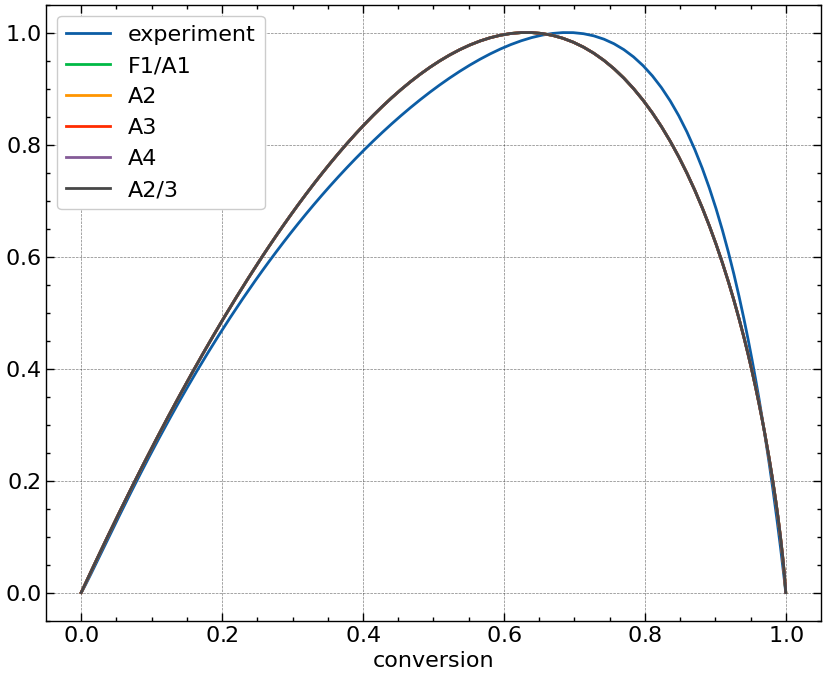

In [7]:
from scipy import integrate
E_MEAN = 67_000

def r2_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def get_exp_term(Ea_mean, temperature):
    return np.exp(Ea_mean / (R * temperature))

def calculate_y_master_plot(da_dt, exp_term):
    y_a = da_dt * exp_term
    y_a_norm = (y_a - y_a.min()) / (y_a.max() - y_a.min())
    return y_a_norm

def calculate_g_master_plot(temperature_a: np.ndarray):
    def integrand(T):
        return np.exp(-E_MEAN / (R * T))
    
    N = len(temperature_a)
    g_values = []
    for i in range(N):
        if i == 0:
            # Для первой точки используем интервал от T[0] до среднего между T[0] и T[1]
            lower_bound = temperature_a[i]
            upper_bound = (temperature_a[i] + temperature_a[i+1]) / 2
        elif i == N - 1:
            # Для последней точки используем интервал от среднего между T[N-2] и T[N-1] до T[N-1]
            lower_bound = (temperature_a[i-1] + temperature_a[i]) / 2
            upper_bound = temperature_a[i]
        else:
            # Для промежуточных точек используем интервал от среднего с предыдущим значением до среднего с последующим
            lower_bound = (temperature_a[i-1] + temperature_a[i]) / 2
            upper_bound = (temperature_a[i] + temperature_a[i+1]) / 2
        
        integral_value, _ = integrate.quad(integrand, lower_bound, upper_bound)
        g_values.append(integral_value)
    
    g_a = np.array(g_values)
    g_norm = (g_a - g_a.min()) / (g_a.max() - g_a.min())
    return g_norm

def calculate_z_master_plot(da_dt, temperature_a: np.ndarray):
    z = da_dt * temperature_a**2
    z_norm = (z - z.min()) / (z.max() - z.min())
    return z_norm


def normalize_data(data):
    data = np.array(data)
    finite_data = data[~np.isinf(data)]
    data_max = np.nanmax(finite_data)
    data_min = np.nanmin(finite_data)
    if data_max == data_min:
        return np.zeros_like(data)
    return (data - data_min) / (data_max - data_min)

def model_r2_scores(experiment_norm, conversion, model_form, z_a=False):
    e = 1 - conversion
    r2_scores = {}
    model_predictions = {}
    for model, funcs in NUC_MODELS_TABLE.items():
        try:
            with warnings.catch_warnings():
                raw_model = (
                    funcs[model_form](e) if not z_a else funcs["differential_form"](e) * funcs["integral_form"](e)
                )
                model_norm = normalize_data(raw_model)
                score = r2_score(experiment_norm, model_norm)
                r2_scores[model] = score
                model_predictions[model] = model_norm
        except Exception as exception:
            print(f"Проблема с моделью {model}: {exception}")

    top_models = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    df_dict = {'conversion': conversion, 'experiment': experiment_norm}
    for model, score in top_models:
        df_dict[model] = model_predictions[model]
    return pd.DataFrame(df_dict)

rate_cols = [col for col in reaction_df.columns if col != "temperature"]
temperature = reaction_df["temperature"].values

y_a_results = {}
g_a_results = {}
z_a_results = {}
for beta in rate_cols:
    da_dT = reaction_df[beta].values

    valid = ~np.isnan(temperature) & ~np.isnan(da_dT)
    da_dT, temperature_valid = da_dT[valid], temperature[valid]
    conversion = da_dT.cumsum() / da_dT.cumsum().max()

    exp_term = get_exp_term(E_MEAN, temperature_valid)
    y_a_norm = calculate_y_master_plot(da_dT, exp_term)
    g_a_norm = calculate_g_master_plot(temperature_valid)
    z_a_norm = calculate_z_master_plot(da_dT, temperature_valid)
    sorted_ya_r2 = model_r2_scores(y_a_norm, conversion, "differential_form")
    sorted_ga_r2 = model_r2_scores(g_a_norm, conversion, "integral_form")
    sorted_za_r2 = model_r2_scores(z_a_norm, conversion, "_", z_a=True)
    y_a_results[beta] = sorted_ya_r2
    g_a_results[beta] = sorted_ga_r2
    z_a_results[beta] = sorted_za_r2


z_a_results["3"].plot(x='conversion', figsize=(10, 8))
